In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mpmath import randmatrix
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sympy.abc import alpha



In [71]:
X, y = make_moons(n_samples=400, noise=0.2, random_state=42)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [72]:
## CONVERT TO TENSORS
X_train_tf = tf.constant(X_train)
y_train_tf = tf.constant(y_train.astype(np.float32))
X_test_tf = tf.constant(X_test)
y_test_tf = tf.constant(y_test.astype(np.float32))


In [73]:
## PARAMETERS
D = X_train.shape[1]
H = 4;
O = 1
W1 = tf.Variable(tf.random.normal([D, H]) * 0.1)
b1 = tf.Variable(tf.zeros([1, H]))
W2 = tf.Variable(tf.random.normal([H, O]) * 0.1)
b2 = tf.Variable(tf.zeros([1, O]))

In [74]:
def relu(x): return tf.maximum(0., x)


def sigmoid(x): return tf.sigmoid(x)

In [75]:
learning_rate = 0.05
epochs = 1000
losses = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        z1 = tf.matmul(X_train_tf, W1) + b1
        a1 = relu(z1)
        logits = tf.matmul(a1, W2) + b2
        probs = sigmoid(logits)
        loss = tf.reduce_mean(
            -(y_train_tf * tf.math.log(probs + 1e-9) + (1 - y_train_tf) * tf.math.log(1 - probs + 1e-9)))
    grads=tape.gradient(loss,[W1,b1,W2,b2])
    W1.assign_add(learning_rate*grads[0])
    b1.assign_sub(learning_rate*grads[1])
    W2.assign_add(learning_rate*grads[2])
    b2.assign_sub(learning_rate*grads[3])
    losses.append(loss)

In [76]:
## Evaluate on test
z1_test=tf.matmul(X_test_tf,W1)+b1
a1_test=relu(z1_test)
logits_test=tf.matmul(a1_test,W2)+b2
probs_test=sigmoid(logits_test)
preds=tf.cast(probs_test>=0.5,tf.float32)
acc=tf.reduce_mean(tf.cast(tf.equal(preds,y_test_tf),tf.float32)).numpy()
print(f"Test Accuracy:- {acc:.4f}")

Test Accuracy:- 0.2500


In [77]:
xx,yy=np.meshgrid(np.linspace(X_train[:,0].min()-0.5,X_train[:,0].max()+0.5,300),np.linspace(X_train[:,1].min()-0.5,X_train[:,1].max()+0.5))
grid_tf=tf.constant(np.c_[xx.ravel(),yy.ravel()].astype(np.float32))
z1g=tf.matmul(grid_tf,W1)+b1
a1g=relu(z1g)
z2g=tf.matmul(a1g,W2)+b2
probsg=tf.sigmoid(z2g).numpy().reshape(xx.shape)



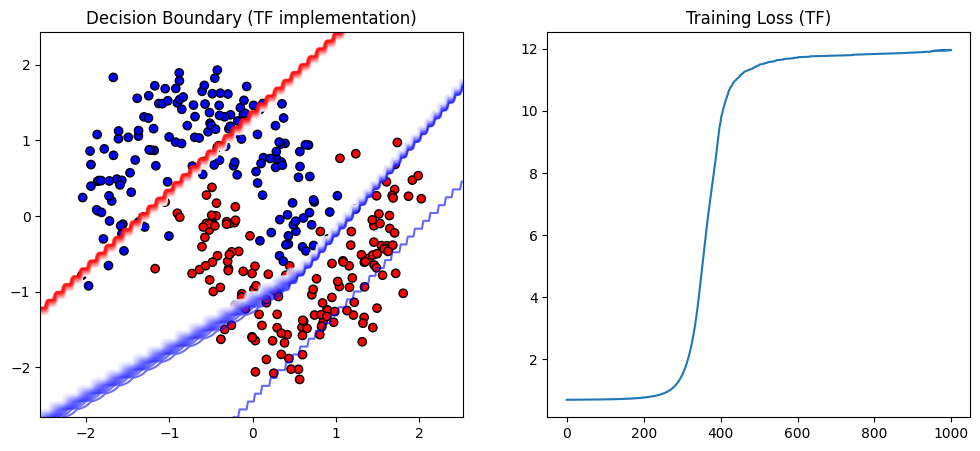

In [78]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contour(xx,yy,probsg,levels=50,cmap="bwr",alpha=0.6)
plt.scatter(X_train[:,0],X_train[:,1],c=y_train[:,0],cmap='bwr',edgecolor='k')
plt.title("Decision Boundary (TF implementation)")
plt.subplot(1,2,2)
plt.plot(losses); plt.title('Training Loss (TF)')
plt.show()

C:\Users\Devarshi\PycharmProjects\PythonProject\.venv1\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Acc: [0.42863520979881287, 0.7749999761581421]


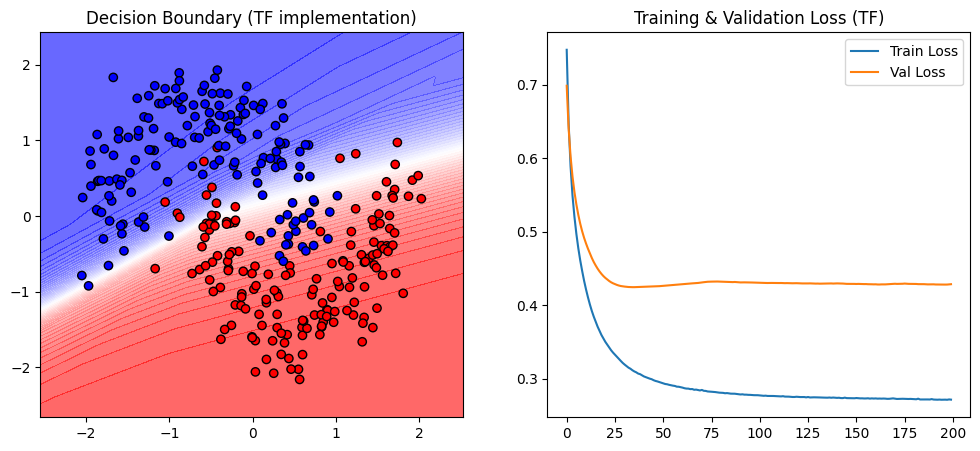

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# -----------------------
# Data
# -----------------------
X, y = make_moons(n_samples=400, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -----------------------
# Model
# -----------------------
model = Sequential([
    Dense(4, activation='relu', input_shape=(2,)),  # input_shape required for first layer
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=200, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0
)

print("Test Acc:", model.evaluate(X_test, y_test, verbose=0))

# -----------------------
# Decision boundary
# -----------------------
xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 300),
    np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 300)
)

# Flatten the grid and make predictions
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid_points, verbose=0)
Z = Z.reshape(xx.shape)

# -----------------------
# Plots
# -----------------------
plt.figure(figsize=(12,5))

# Decision boundary
plt.subplot(1,2,1)
plt.contourf(xx, yy, Z, levels=50, cmap="bwr", alpha=0.6)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr', edgecolor='k')
plt.title("Decision Boundary (TF implementation)")

# Training loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Loss (TF)')

plt.show()
